#Building a simple GAN

## Importing files and libraries

In [1]:

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [17]:
from google.colab import files
files.upload()

Saving EGFR_smiles.smi to EGFR_smiles.smi


{'EGFR_smiles.smi': b'CN(C)C/C=C/C(=O)N1Cc2sc3ncnc(Nc4ccc(F)c(Cl)c4)c3c2C1\nCN(C/C=C/C(=O)N1CCc2c(sc3ncnc(Nc4cc(O)c(Cl)c(Cl)c4)c23)C1)C(C)(C)C\nCOc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1\nCCOc1cc2ncc(C#N)c(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)/C=C/CN(C)C\nCN(C)Cc1ccc(-c2cc3ncnc(Nc4ccc(OCc5cccc(F)c5)c(Cl)c4)c3s2)o1\nOCc1ccc(-c2cc3ncnc(Nc4ccc(OCc5cccc(F)c5)c(Cl)c4)c3s2)o1\nFc1cccc(COc2ccc(Nc3ncnc4cc(-c5cccs5)sc34)cc2Cl)c1\nFc1cccc(COc2ccc(Nc3ncnc4sc(-c5ccc(CNCc6ccccc6)o5)cc34)cc2Cl)c1\nCN(C)Cc1ccc(-c2cc3c(Nc4ccc(OCc5cccc(F)c5)c(Cl)c4)ncnc3s2)[nH]1\nCCNCc1ccc(-c2cc3c(Nc4ccc(OCc5cccc(F)c5)c(Cl)c4)ncnc3s2)[nH]1\nCC(C)n1c(Nc2ccc(F)c(Cl)c2)nc2cnc(Nc3ccc(N4CCN(C)CC4)cc3)nc21\nCC(C)n1c(Nc2cccc(C(F)(F)F)c2)nc2cnc(Nc3ccc(N4CCN(C)CC4)cc3)nc21\nCOc1cc(OC)cc(-c2ccc3c(c2)NC(=O)/C3=C\\c2[nH]c(C)c(CCC(=O)O)c2C)c1\nFc1cccc(COc2ccc(Nc3ncnc4sc(-c5ccc[nH]5)cc34)cc2Cl)c1\nNc1ncnc2c1c(-c1ccc(Oc3ccccc3)cc1)nn2C1CCN(C(=O)/C=C/CN2CCOCC2)CC1\nC=CC(=O)Nc1cccc(N2C(=O)N(c3ccc(OCc4ccccc4)cc3)Cc3cnc(Nc4ccc(N5CCN(C)CC5)cc4

In [18]:
import pandas as pd
df=pd.read_csv("EGFR_smiles.smi",header=None)
#df=pd.read_csv('generated_mols.smi',header=None)
df

,0
0,CN(C)C/C=C/C(=O)N1Cc2sc3ncnc(Nc4ccc(F)c(Cl)c4)...
1,CN(C/C=C/C(=O)N1CCc2c(sc3ncnc(Nc4cc(O)c(Cl)c(C...
2,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1
3,CCOc1cc2ncc(C#N)c(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)...
4,CN(C)Cc1ccc(-c2cc3ncnc(Nc4ccc(OCc5cccc(F)c5)c(...
...,...
13797,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1
13798,C=CC(=O)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1
13799,C=CC(=O)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1
13800,N#C/C(=C\c1ccc(O)c(O)c1)C(=O)NCc1ccccc1


## Converting SMILES to one-hot encoded matrix

In [19]:
import numpy as np
data=df.to_numpy()
values = array(data)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

#Reverse
fake_inverted= label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
print(fake_inverted)
print(values[0])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3026 3234 5114 ... 1106 7134 6196]
['CN(C)C/C=C/C(=O)N1Cc2sc3ncnc(Nc4ccc(F)c(Cl)c4)c3c2C1']
['CN(C)C/C=C/C(=O)N1Cc2sc3ncnc(Nc4ccc(F)c(Cl)c4)c3c2C1']


In [20]:
import numpy as np
np.shape(onehot_encoded[0])

(8830,)

## Coding Discriminator and Generator

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard



class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x.float())


class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, img_dim),
            nn.Tanh(),  # normalize inputs to [-1, 1] so make outputs [-1, 1]
        )

    def forward(self, x):
        return self.gen(x.float())



## Hyperparameter tuning and training the model

In [39]:
# Hyperparameters etc.
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 64
img_dim = 8830 * 1  #size of one hot encoding
batch_size = 16 
num_epochs = 100
gen_mols=[]

disc = Discriminator(img_dim).to(device)
gen = Generator(z_dim, img_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)
'''transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),]
)'''

#dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
dataset= onehot_encoded
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
#print(enumerate(loader))
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()
writer_fake = SummaryWriter(f"logs/fake")
writer_real = SummaryWriter(f"logs/real")
step = 0


for epoch in range(num_epochs):      
    for (batch_idx, real) in enumerate(loader):
    #for real in enumerate(loader):
        
        #real = real.view(-1, img_dim).to(device)
        real=real.to(device)
        batch_size = real.shape[0]

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # where the second option of maximizing doesn't suffer from
        # saturating gradients
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, img_dim)
                data = real.reshape(-1, 1, img_dim)
                print(np.shape(fake))
                print(np.shape(data))
                data1=data.cpu().detach().numpy()
                data1=data1.reshape(img_dim*batch_size,1)
                data1=data1.transpose()
                data1=data1.flatten()
                print(np.shape(data1))
                print(data1)
                fake1=fake.cpu().detach().numpy()
                fake1=fake1.reshape(img_dim*batch_size,1)
                fake1=fake1.transpose()
                fake1=fake1.flatten()
                print(np.shape(fake1))
                print(fake1)
                real_inverted = label_encoder.inverse_transform([argmax(data1)])
                fake_inverted=label_encoder.inverse_transform([argmax(fake1[(img_dim*(batch_size-1)):(img_dim*batch_size-1)])]) 
                
                if(num_epochs%5==0):
                   gen_mols.append(fake_inverted)
                             
             
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                #writer_fake.add_image(
                 #   "Mnist Fake Images", img_grid_fake, global_step=step
                #)
                #writer_real.add_image(
                 #   "Mnist Real Images", img_grid_real, global_step=step
                #)
                step += 1

Epoch [0/100] Batch 0/863                       Loss D: 0.6995, loss G: 1.0825
torch.Size([16, 1, 8830])
torch.Size([16, 1, 8830])
(141280,)
[0. 0. 0. ... 0. 0. 0.]
(141280,)
[-0.01766061  0.2859132  -0.3146533  ... -0.17603129 -0.15425968
 -0.12510218]
Epoch [1/100] Batch 0/863                       Loss D: 0.2824, loss G: 3.0690
torch.Size([16, 1, 8830])
torch.Size([16, 1, 8830])
(141280,)
[0. 0. 0. ... 0. 0. 0.]
(141280,)
[0.01379885 0.01420992 0.00163884 ... 0.023895   0.01692099 0.01273997]
Epoch [2/100] Batch 0/863                       Loss D: 0.6179, loss G: 0.8009
torch.Size([16, 1, 8830])
torch.Size([16, 1, 8830])
(141280,)
[0. 0. 0. ... 0. 0. 0.]
(141280,)
[ 0.00834117 -0.00349772 -0.00429536 ... -0.00706736 -0.00413139
 -0.0019235 ]
Epoch [3/100] Batch 0/863                       Loss D: 0.6083, loss G: 0.8465
torch.Size([16, 1, 8830])
torch.Size([16, 1, 8830])
(141280,)
[0. 0. 0. ... 0. 0. 0.]
(141280,)
[-0.00618749 -0.0209798   0.00272189 ...  0.0069639  -0.00311288
 -0.0

In [40]:
#print(data[0])
#print(fake_inverted)
print(gen_mols)
print(np.shape(gen_mols))

[array(['COc1cc(N2CCN(CC(=O)N(C)C)C2=O)ccc1Nc1ncc(Cl)c(Nc2ccccc2S(=O)(=O)C(C)C)n1'],
      dtype=object), array(['Brc1cccc(Nc2nnnc3ccccc23)c1'], dtype=object), array(['C=CC(=O)Nc1cccc(-n2c(=O)c(Cc3ccccc3)cc3cnc(Nc4ccc(N5CCN(C)CC5)cc4OC)nc32)c1'],
      dtype=object), array(['CC(=O)N1CCC[C@@H]1C#Cc1cc2ncnc(Nc3ccc(OCc4cccc(F)c4)c(Cl)c3)c2s1'],
      dtype=object), array(['COc1ccc(CNc2ncnc3ccccc23)cc1'], dtype=object), array(['COc1cc(Nc2c(C#N)cnc3cc4[nH]c(CN5CCOCC5)nc4cc23)cc(OC)c1OC'],
      dtype=object), array(['COc1cc2ncnc(Sc3cccc(Cl)c3)c2cc1OC'], dtype=object), array(['COc1cc(Nc2c(C#N)cnc3cc4[nH]c(CN5CCOCC5)nc4cc23)cc(OC)c1OC'],
      dtype=object), array(['CC(=O)N1CCC[C@@H]1C#Cc1cc2ncnc(Nc3ccc(OCc4cccc(F)c4)c(Cl)c3)c2s1'],
      dtype=object), array(['COc1ccc(-c2nn(C3CCC3)c3ncnc(N)c23)cc1OC'], dtype=object), array(['C=CC(=O)Nc1cccc(Nc2nc(Nc3ccc(N4CCN(C(C)=O)CC4)cc3OC)ncc2C(F)(F)F)c1'],
      dtype=object), array(['CC(C)(C)c1ccc(-c2nnc(SCc3ccccc3)o2)cc1'], dtype=object), array(['COc1

In [41]:
df=pd.DataFrame(gen_mols)
df

,0
0,COc1cc(N2CCN(CC(=O)N(C)C)C2=O)ccc1Nc1ncc(Cl)c(...
1,Brc1cccc(Nc2nnnc3ccccc23)c1
2,C=CC(=O)Nc1cccc(-n2c(=O)c(Cc3ccccc3)cc3cnc(Nc4...
3,CC(=O)N1CCC[C@@H]1C#Cc1cc2ncnc(Nc3ccc(OCc4cccc...
4,COc1ccc(CNc2ncnc3ccccc23)cc1
...,...
95,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1
96,CN(C)N1C(=O)c2c(c3c4cccc(O)c4n(C4OC(CO)C(O)C(O...
97,Nc1ncnc2c1c(-c1ccc(Oc3ccccc3)cc1)nn2C[C@@H]1CC...
98,C=CCCCCCCN1CCOC(COc2cc3ncnc(Nc4ccc(Cl)c(Cl)c4)...


## Calculting Synthetic Accessiblity and QED scores

In [2]:
!pip install kora -q
import kora.install.rdkit
import rdkit

     |████████████████████████████████| 57 kB 2.7 MB/s 
     |████████████████████████████████| 60 kB 5.7 MB/s 


In [3]:
import rdkit
import sys
try:
    # doesnt work for github CI/pypi install. 
    # SA score is only in the contrib dir for RDKit conda install
    sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
    sys.path.append(rdkit.__path__[0])
    import sascorer
except:
    # download SA score 
    import requests
    files = [
        'https://raw.githubusercontent.com/rdkit/rdkit/master/Contrib/SA_Score/sascorer.py',
        'https://raw.githubusercontent.com/rdkit/rdkit/master/Contrib/SA_Score/fpscores.pkl.gz'
    ]

    for file in files:
        r = requests.get(file)
        with open(rdkit.__path__[0]+'/'+file.split('/')[-1], 'wb') as f:
            f.write(r.content)
            
    sys.path.append(rdkit.__path__[0])
            
    import sascorer

In [4]:
from rdkit import Chem
from rdkit.Chem import QED
mols=['COc1cc(N2CCN(CC(=O)N(C)C)C2=O)ccc1Nc1ncc(Cl)c(Nc2ccccc2S(=O)(=O)C(C)C)n1','C=CC(=O)Nc1cccc(-n2c(=O)c(Cc3ccccc3)cc3cnc(Nc4ccc(N5CCN(C)CC5)cc4OC)nc32)c1',
      'C=CCCCCCCN1CCOC(COc2cc3ncnc(Nc4ccc(Cl)c(Cl)c4)c3cc2OC)C1','CN(C)N1C(=O)c2c(c3c4cccc(O)c4n(C4OC(CO)C(O)C(O)C4O)c3c3[nH]c4c(O)cccc4c23)C1=O',
      'COc1cc2c(Nc3ccc(Cl)c(Cl)c3)ncnc2cc1OC[C@@H]1CN2CCC[C@@H]2CO1','COc1cccc(-c2cn(C3CCNC3)c3ncnc(N)c23)c1',
      '	COc1ccc2c(c1)cc(C1C(C#N)=C(N)N(c3cccnc3)C3=C1C(=O)CCC3)c1nnnn12','Cc1ccc(Nc2ncnn3ccc(C)c23)cc1O',
      'Cc1cn2c(-c3cn[nH]c3)cnc2c(Nc2cc(CN3CCC(F)(F)C3)ns2)n1.Cl','Cc1ccc(NC(=O)c2ccc(Cl)cc2)cc1Nc1nccc(-c2cccnc2)n1',
      'O=C1Nc2ccccc2/C1=C/c1ccc(Br)cc1','Fc1ccc(Nc2ncnc3nc(Nc4ccc(CN5CCCC5)cc4)sc23)cc1Cl']
sa_scores=[]
qed_scores=[]
for x in mols:
  mol = Chem.MolFromSmiles(x)
  sa_scores.append(sascorer.calculateScore(mol))
  qed_scores.append(QED.qed(mol))  
print('SA scores:',sa_scores)
print('QED Scores :',qed_scores)

SA scores: [2.9198418099983545, 2.8721762989519473, 3.118180245589379, 4.570563010325333, 3.299849236523907, 2.905326885224996, 3.5062405914390755, 2.5128694563450296, 3.543824982964434, 2.0802676666904443, 1.924718384571797, 2.450718242909245]
QED Scores : [0.3511032624402641, 0.22767284649666852, 0.18503111218584045, 0.15537895675589217, 0.5423202153320402, 0.7754718713804367, 0.4851502900596401, 0.7378179030908203, 0.4774112875713098, 0.4497668861319504, 0.7940514367271883, 0.3743304669705052]


### SA scores
1->Easy to synthesize<br>
10-> Difficult to synthesize

### QED scores
0-> not drug like<br>
1-> drug like


## Drawing the compounds

COc1cc(N2CCN(CC(=O)N(C)C)C2=O)ccc1Nc1ncc(Cl)c(Nc2ccccc2S(=O)(=O)C(C)C)n1
SA score:  2.9198418099983545
QED score:  0.3511032624402641
Toxic :  No
Soluble :  No
EGFR bioactivity :  Active


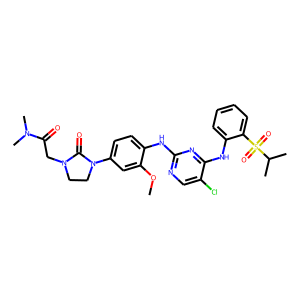

C=CC(=O)Nc1cccc(-n2c(=O)c(Cc3ccccc3)cc3cnc(Nc4ccc(N5CCN(C)CC5)cc4OC)nc32)c1
SA score:  2.8721762989519473
QED score:  0.22767284649666852
Toxic :  No
Soluble :  Yes
EGFR bioactivity :  Active


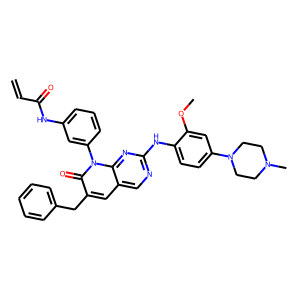

C=CCCCCCCN1CCOC(COc2cc3ncnc(Nc4ccc(Cl)c(Cl)c4)c3cc2OC)C1
SA score:  3.118180245589379
QED score:  0.18503111218584045
Toxic :  No
Soluble :  No
EGFR bioactivity :  Active


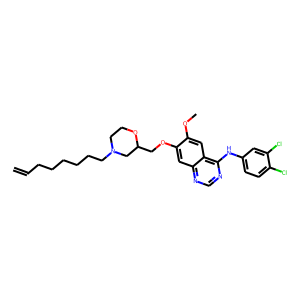

CN(C)N1C(=O)c2c(c3c4cccc(O)c4n(C4OC(CO)C(O)C(O)C4O)c3c3[nH]c4c(O)cccc4c23)C1=O
SA score:  4.570563010325333
QED score:  0.15537895675589217
Toxic :  Yes
Soluble :  Yes
EGFR bioactivity :  Inactive


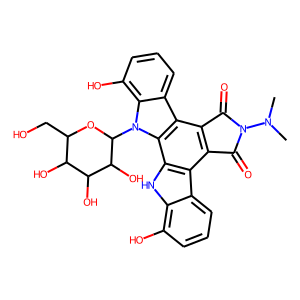

COc1cc2c(Nc3ccc(Cl)c(Cl)c3)ncnc2cc1OC[C@@H]1CN2CCC[C@@H]2CO1
SA score:  3.299849236523907
QED score:  0.5423202153320402
Toxic :  No
Soluble :  Yes
EGFR bioactivity :  Active


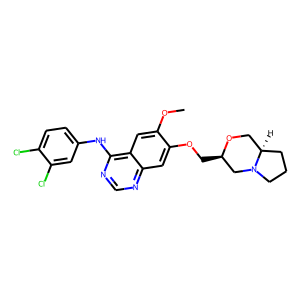

COc1cccc(-c2cn(C3CCNC3)c3ncnc(N)c23)c1
SA score:  2.905326885224996
QED score:  0.7754718713804367
Toxic :  Yes
Soluble :  Yes
EGFR bioactivity :  Inactive


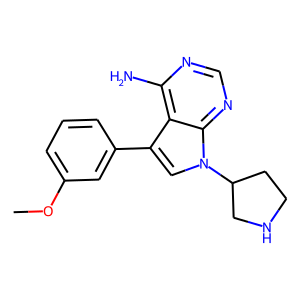

	COc1ccc2c(c1)cc(C1C(C#N)=C(N)N(c3cccnc3)C3=C1C(=O)CCC3)c1nnnn12
SA score:  3.5062405914390755
QED score:  0.4851502900596401
Toxic :  No
Soluble :  Yes
EGFR bioactivity :  Inactive


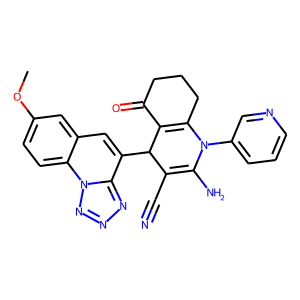

Cc1ccc(Nc2ncnn3ccc(C)c23)cc1O
SA score:  2.5128694563450296
QED score:  0.7378179030908203
Toxic :  Yes
Soluble :  No
EGFR bioactivity :  Inactive


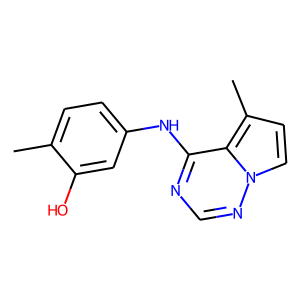

Cc1cn2c(-c3cn[nH]c3)cnc2c(Nc2cc(CN3CCC(F)(F)C3)ns2)n1.Cl
SA score:  3.543824982964434
QED score:  0.4774112875713098
Toxic :  No
Soluble :  Yes
EGFR bioactivity :  Active


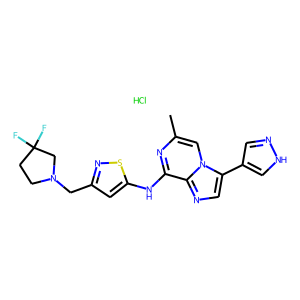

Cc1ccc(NC(=O)c2ccc(Cl)cc2)cc1Nc1nccc(-c2cccnc2)n1
SA score:  2.0802676666904443
QED score:  0.4497668861319504
Toxic :  No
Soluble :  No
EGFR bioactivity :  Inactive


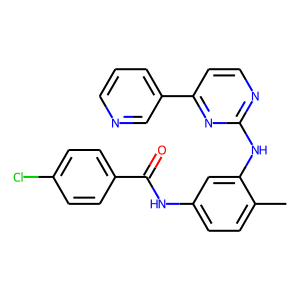

O=C1Nc2ccccc2/C1=C/c1ccc(Br)cc1
SA score:  1.924718384571797
QED score:  0.7940514367271883
Toxic :  Yes
Soluble :  No
EGFR bioactivity :  Inactive


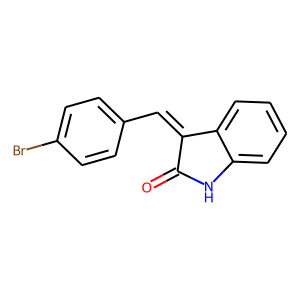

Fc1ccc(Nc2ncnc3nc(Nc4ccc(CN5CCCC5)cc4)sc23)cc1Cl
SA score:  2.450718242909245
QED score:  0.3743304669705052
Toxic :  No
Soluble :  No
EGFR bioactivity :  Active


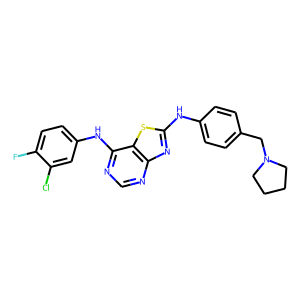

In [6]:
from rdkit.Chem import Draw
index=0
toxicity=['No','No','No','Yes','No','Yes','No','Yes','No','No','Yes','No']
solubility=['No','Yes','No','Yes','Yes','Yes','Yes','No','Yes','No','No','No']
activity=['Active','Active','Active','Inactive','Active','Inactive','Inactive','Inactive','Active','Inactive','Inactive','Active']
for x in mols:       
    print(x)
    print('SA score: ',sa_scores[index])
    print('QED score: ',qed_scores[index])
    print('Toxic : ',toxicity[index])
    print('Soluble : ',solubility[index])
    print('EGFR bioactivity : ',activity[index])
    img = Draw.MolToImage(Chem.MolFromSmiles(x))
    display(img)
    index+=1


## Exporting generated molecules smiles file

In [43]:
mols=pd.DataFrame(mols)
mols.to_csv('gen_mols.smi',header=None,index=False)